# Klasifikasi Tingkat Keganasan Tumor Otak

In [1]:
import os
import time

import pathlib

import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array,  load_img

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

from IPython.display import display, Markdown

## Pengaturan Hyperparameter dan Konfigurasi Model

In [2]:
# Menginisialisasi learning rate, jumlah epoch, dan jumlah batch size
INIT_LR = 1e-4
EPOCHS = 30
BS = 32
SIZE_X = 112
SIZE_Y = 112

NETWORK = "ResNet50V2_Tesis_SMOTE"

dataset = r"C:\Users\Lab129\Downloads\Indi\Dataset Kla 128";
model_path = NETWORK + "_" + str(EPOCHS) + ".model"

## Pre-processing Data

In [3]:
data_dir = pathlib.Path(dataset)

print("[INFO] loading images...")
df = pd.DataFrame(
    [(str(dir), str(dir).split(os.path.sep)[-3]) for dir in data_dir.glob("**/*.jpg")],
    columns=["image", "label"],
)

# Mengatur tipe data
df["image"] = df["image"].astype('string')
df["label"] = df["label"].astype('category')
df.info()

[INFO] loading images...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47232 entries, 0 to 47231
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   image   47232 non-null  string  
 1   label   47232 non-null  category
dtypes: category(1), string(1)
memory usage: 415.4 KB


In [4]:
df["label"].cat.categories, df["label"].cat.codes.unique()

(Index(['HGG', 'LGG'], dtype='object'), array([0, 1], dtype=int8))

In [5]:
# Memeriksa ketidakseimmbangan kelas
class_count = df["label"].value_counts()
display(class_count)

HGG    37504
LGG     9728
Name: label, dtype: int64

In [6]:
# Lakukan pengkodean one-hot encoding pada label
label_encoder = LabelBinarizer()
label_encoded = label_encoder.fit_transform(df["label"])
label_one_hot_encoded = to_categorical(label_encoded)

In [7]:
def image_reader(path: str):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [SIZE_X, SIZE_Y])
    image = preprocess_input(image)
    return image

def image_generator(path: str, label):
    image = image_reader(path)
    return image, label

In [8]:
# Membagi data menjadi set pelatihan dan set pengujian
X_train, X_test, y_train, y_test = train_test_split(
    df["image"], label_one_hot_encoded, test_size=0.20, random_state=42, stratify=df["label"]
)

display(Markdown((
    f"**Train images count**: {X_train.count()}\n\n"
    f"**Test images count**: {X_test.count()}"
)))

**Train images count**: 37785

**Test images count**: 9447

In [9]:
# Menginisialisasi objek SMOTE
sm = SMOTE(random_state=42)

# Melakukan resample dataset
X_train_idx, y_train = sm.fit_resample(X_train.index.values.reshape(-1, 1), y_train)

X_train = df.iloc[X_train_idx.flatten()]["image"]
y_train = to_categorical(y_train)


display(Markdown((
    f"**Train images count**: {X_train.count()}\n\n"
    f"**Test images count**: {X_test.count()}"
)))

**Train images count**: 60006

**Test images count**: 9447

In [10]:
train_total_items = len(X_train)
train_num_batches = train_total_items // BS
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(
    image_generator, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(train_total_items).repeat(EPOCHS).batch(BS).prefetch(tf.data.AUTOTUNE)

val_total_items = len(X_test)
val_num_batches = val_total_items // BS
val_dataset =  tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(
    image_generator, num_parallel_calls=tf.data.AUTOTUNE
).batch(BS).prefetch(tf.data.AUTOTUNE)

## Pengembangan Model

In [11]:
starttime = time.time()
# Memuat jaringan MobileNetV2, memastikan adanya kumpulan lapisan
baseModel = ResNet50V2(weights="imagenet", include_top=False,
                       input_tensor=Input(shape=(SIZE_X, SIZE_Y, 3)))

# baseModel = MobileNetV2(weights="imagenet", include_top=False,
#                         input_tensor=Input(shape=(SIZE_X, SIZE_Y, 3)))

# baseModel = InceptionResNetV2(weights="imagenet", include_top=False,
#                               input_tensor=Input(shape=(SIZE_X, SIZE_Y, 3)))

baseModel.trainable = False

# Membangun head model
headModel = baseModel.output  # outshape = 4 x 4 x 1280 channel
print(headModel.shape)

headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Tempatkan head model di atas base model
model = Model(inputs=baseModel.input, outputs=headModel)
# model.summary

(None, 4, 4, 1280)


In [12]:
# Lakukan kompilasi model (mengukur accuracy)
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

[INFO] compiling model...


## Proses Pelatihan Model

In [13]:
# Lakukan pelatihan untuk head network
print("[INFO] training head...")
H = model.fit(train_dataset,
              batch_size=BS, 
              verbose=1, 
              steps_per_epoch=train_num_batches,
              epochs=EPOCHS, 
              validation_data=val_dataset,
              validation_steps=val_num_batches,
              validation_batch_size=BS,
              shuffle=False)

[INFO] training head...
Epoch 1/30
1875/1875 [==============================] - 212s 74ms/step - loss: 0.3876 - accuracy: 0.8220 - val_loss: 0.4250 - val_accuracy: 0.8097
Epoch 2/30
1875/1875 [==============================] - 128s 68ms/step - loss: 0.1848 - accuracy: 0.9207 - val_loss: 0.1870 - val_accuracy: 0.9221
Epoch 3/30
1875/1875 [==============================] - 115s 62ms/step - loss: 0.1131 - accuracy: 0.9518 - val_loss: 0.1431 - val_accuracy: 0.9338
Epoch 4/30
1875/1875 [==============================] - 101s 54ms/step - loss: 0.0802 - accuracy: 0.9650 - val_loss: 0.1952 - val_accuracy: 0.9280
Epoch 5/30
1875/1875 [==============================] - 90s 48ms/step - loss: 0.0637 - accuracy: 0.9715 - val_loss: 0.1239 - val_accuracy: 0.9538
Epoch 6/30
1875/1875 [==============================] - 79s 42ms/step - loss: 0.0521 - accuracy: 0.9763 - val_loss: 0.1295 - val_accuracy: 0.9530
Epoch 7/30
1875/1875 [==============================] - 74s 39ms/step - loss: 0.0420 - accuracy:

## Uji Coba dan Evaluasi Model

In [14]:
# Buat prediksi pada set pengujian
print("[INFO] evaluating network...")
predIdxs = model.predict(val_dataset, batch_size=BS)

# Untuk setiap gambar dalam set pengujian kita perlu menemukan indeks file label dengan probabilitas prediksi terbesar yang sesuai
predIdxs = np.argmax(predIdxs, axis=1)

endtime = time.time()

# Tampilkan classification report
print(classification_report(y_test.argmax(axis=1), predIdxs,
                            target_names=df["label"].cat.categories))

# Tampilkan running time
print("Running time: {} s".format(endtime - starttime))

[INFO] evaluating network...
              precision    recall  f1-score   support

         HGG       0.99      0.96      0.97      7501
         LGG       0.85      0.96      0.90      1946

    accuracy                           0.96      9447
   macro avg       0.92      0.96      0.94      9447
weighted avg       0.96      0.96      0.96      9447

Running time: 2043.5096752643585 s


## Penyimpanan Model dan Visualisasi

[INFO] saving brain tumor malignancy detector model...


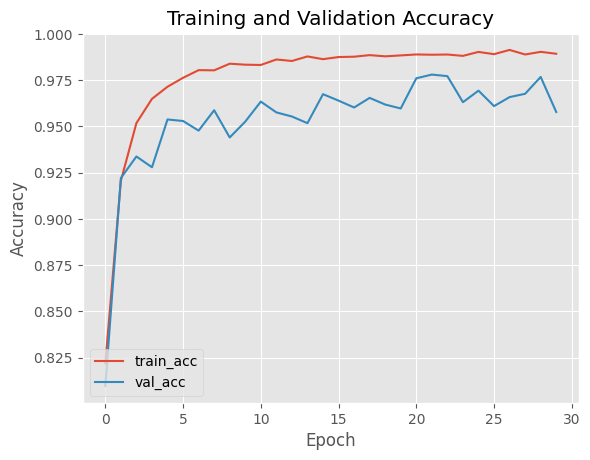

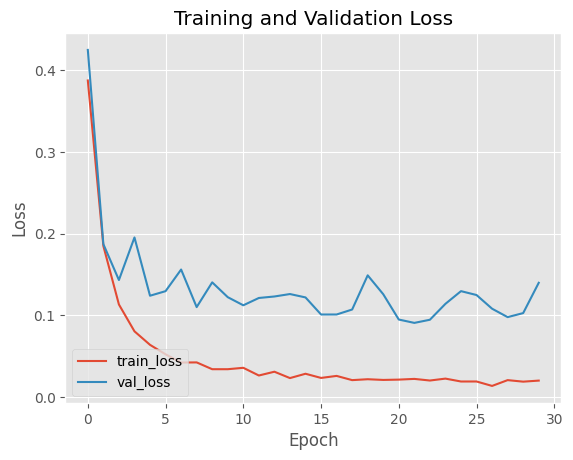

In [15]:
# Lakukan penyimpanan model
print("[INFO] saving brain tumor malignancy detector model...")
model.save(model_path, save_format="h5")  # Save dalam format .h5

# Munculkan hasil klasifikasi dan kompilasi dari pelatihan data
epochs_range = range(EPOCHS)

plt.style.use("ggplot")
plt.figure()
plt.plot(epochs_range, H.history["accuracy"], label="train_acc")
plt.plot(epochs_range, H.history["val_accuracy"], label="val_acc")
plt.legend(loc='lower left')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.style.use("ggplot")
plt.figure()
plt.plot(epochs_range, H.history["loss"], label="train_loss")
plt.plot(epochs_range, H.history["val_loss"], label="val_loss")
plt.legend(loc="lower left")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()